In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize, curve_fit
from utility.process import convert_ed
from utility.gen_dataset import gen_dataset

# Data Processing

- Need to generate 10 different response curves from kaustubh's simulation
- Store parameters in panda table

In [2]:
# original function
def get_true_quantile(r_true, quantile=0.5):
    i = np.arange(len(r_true))
    c = np.cumsum(r_true)
    q = np.searchsorted(c, quantile*c[-1])
    return np.where(c[q]/c[-1] == quantile, 0.5 * (i[q] + i[q+1]), i[q])

# wrapper function for getting all true edh bins
def get_all_true_quantlies(r_true, quantiles):
    bins = []
    for qnt in quantiles:
        bins.append(get_true_quantile(r_true, quantile=qnt))
    return bins

In [3]:
# test above
def oracle_edh(tr, n_edh):
    bins = tr.shape[-1]
    tr_cs = np.cumsum(tr)
    tr_sum = np.sum(tr)
    edh_bins = np.zeros((n_edh-1))
    for idx in range(edh_bins.shape[-1]):
        edh_bins[idx] = np.argmin(np.abs(tr_cs - tr_sum*(idx+1.0)/n_edh))
    return edh_bins+1

# bins, trs = gen_dataset(bins=16)
# oracle_bins = oracle_edh(trs, 16)
# quantiles = []
# for idx, bd in enumerate(bins):
#     quantiles.append(np.sum(trs[:int(bd)])/np.sum(trs)*100)
# quantile_bins = get_all_true_quantlies(trs, quantiles)
# print(oracle_bins-quantile_bins)

In [44]:
# generate gaussian and return necessary parameters
def gen_gauss(a, b, c, x_range):
    return a*np.exp(-(x_range - b)**2 / (2*c**2))

def get_true_gauss_params(height, width, ambient, depth, bins):
    gauss = gen_gauss(height, depth, width/2.355, np.arange(1000)) + ambient
    return {
        'height': height,
        'width': width,
        'ambient': ambient,
        'depth': depth,
        'edh_bds': oracle_edh(gauss, bins),
        'data_pts': gauss
    }

In [45]:
# generate 10 raw gaussian datasets w/ boundaries
# store a ground-truth and blind copy to a *.pkl file

# constants
BINS = 16
HEIGHT_RANGE = (50, 950)
PULSE_WIDTH_RANGE = (10, 50)
AMBIENT_RANGE = (10, 100)
DEPTH_RANGE = (50, 950)

SAMPLE_COUNT = 10

# generation code
rng = np.random.default_rng()
data = []
for i in range(SAMPLE_COUNT):
    height = rng.uniform(low=HEIGHT_RANGE[0], high=HEIGHT_RANGE[1])
    width = rng.uniform(low=PULSE_WIDTH_RANGE[0], high=PULSE_WIDTH_RANGE[1])
    ambient = rng.uniform(low=AMBIENT_RANGE[0], high=AMBIENT_RANGE[1])
    depth = rng.uniform(low=DEPTH_RANGE[0], high=DEPTH_RANGE[1])
    data.append(get_true_gauss_params(height, width, ambient, depth, BINS))
df = pd.DataFrame(data)
df.to_pickle('data/ground-truth.pkl')
df

,height,width,ambient,depth,edh_bds,data_pts
0,508.836874,43.897713,61.582455,317.195227,"[87.0, 173.0, 260.0, 297.0, 309.0, 319.0, 329....","[61.58245511989376, 61.58245511989376, 61.5824..."
1,178.466996,41.932925,95.898985,909.540720,"[68.0, 135.0, 203.0, 271.0, 338.0, 406.0, 474....","[95.8989849335084, 95.8989849335084, 95.898984..."
2,904.295092,16.710279,92.641017,378.527548,"[73.0, 147.0, 220.0, 293.0, 364.0, 377.0, 384....","[92.64101713749464, 92.64101713749464, 92.6410..."
3,111.752458,46.104461,77.615518,452.140374,"[67.0, 134.0, 201.0, 268.0, 335.0, 401.0, 444....","[77.61551818013344, 77.61551818013344, 77.6155..."
4,782.538681,36.079700,34.735567,167.037605,"[116.0, 148.0, 156.0, 162.0, 167.0, 172.0, 177...","[34.735566759365796, 34.735566759365796, 34.73..."
5,306.046827,44.574387,43.928286,517.482606,"[83.0, 166.0, 249.0, 333.0, 416.0, 485.0, 504....","[43.928286264261125, 43.928286264261125, 43.92..."
6,422.858482,27.280284,19.809470,134.375225,"[100.0, 122.0, 128.0, 133.0, 138.0, 143.0, 150...","[19.809469752196556, 19.809469752196556, 19.80..."
7,538.723448,40.097718,84.221771,741.173637,"[80.0, 159.0, 239.0, 318.0, 398.0, 477.0, 557....","[84.22177104195138, 84.22177104195138, 84.2217..."
8,927.354975,19.208191,93.036350,501.644309,"[75.0, 150.0, 226.0, 301.0, 376.0, 451.0, 494....","[93.03635015233971, 93.03635015233971, 93.0363..."
9,670.658305,35.985868,20.141786,737.684603,"[142.0, 284.0, 427.0, 569.0, 701.0, 719.0, 726...","[20.14178613097967, 20.14178613097967, 20.1417..."


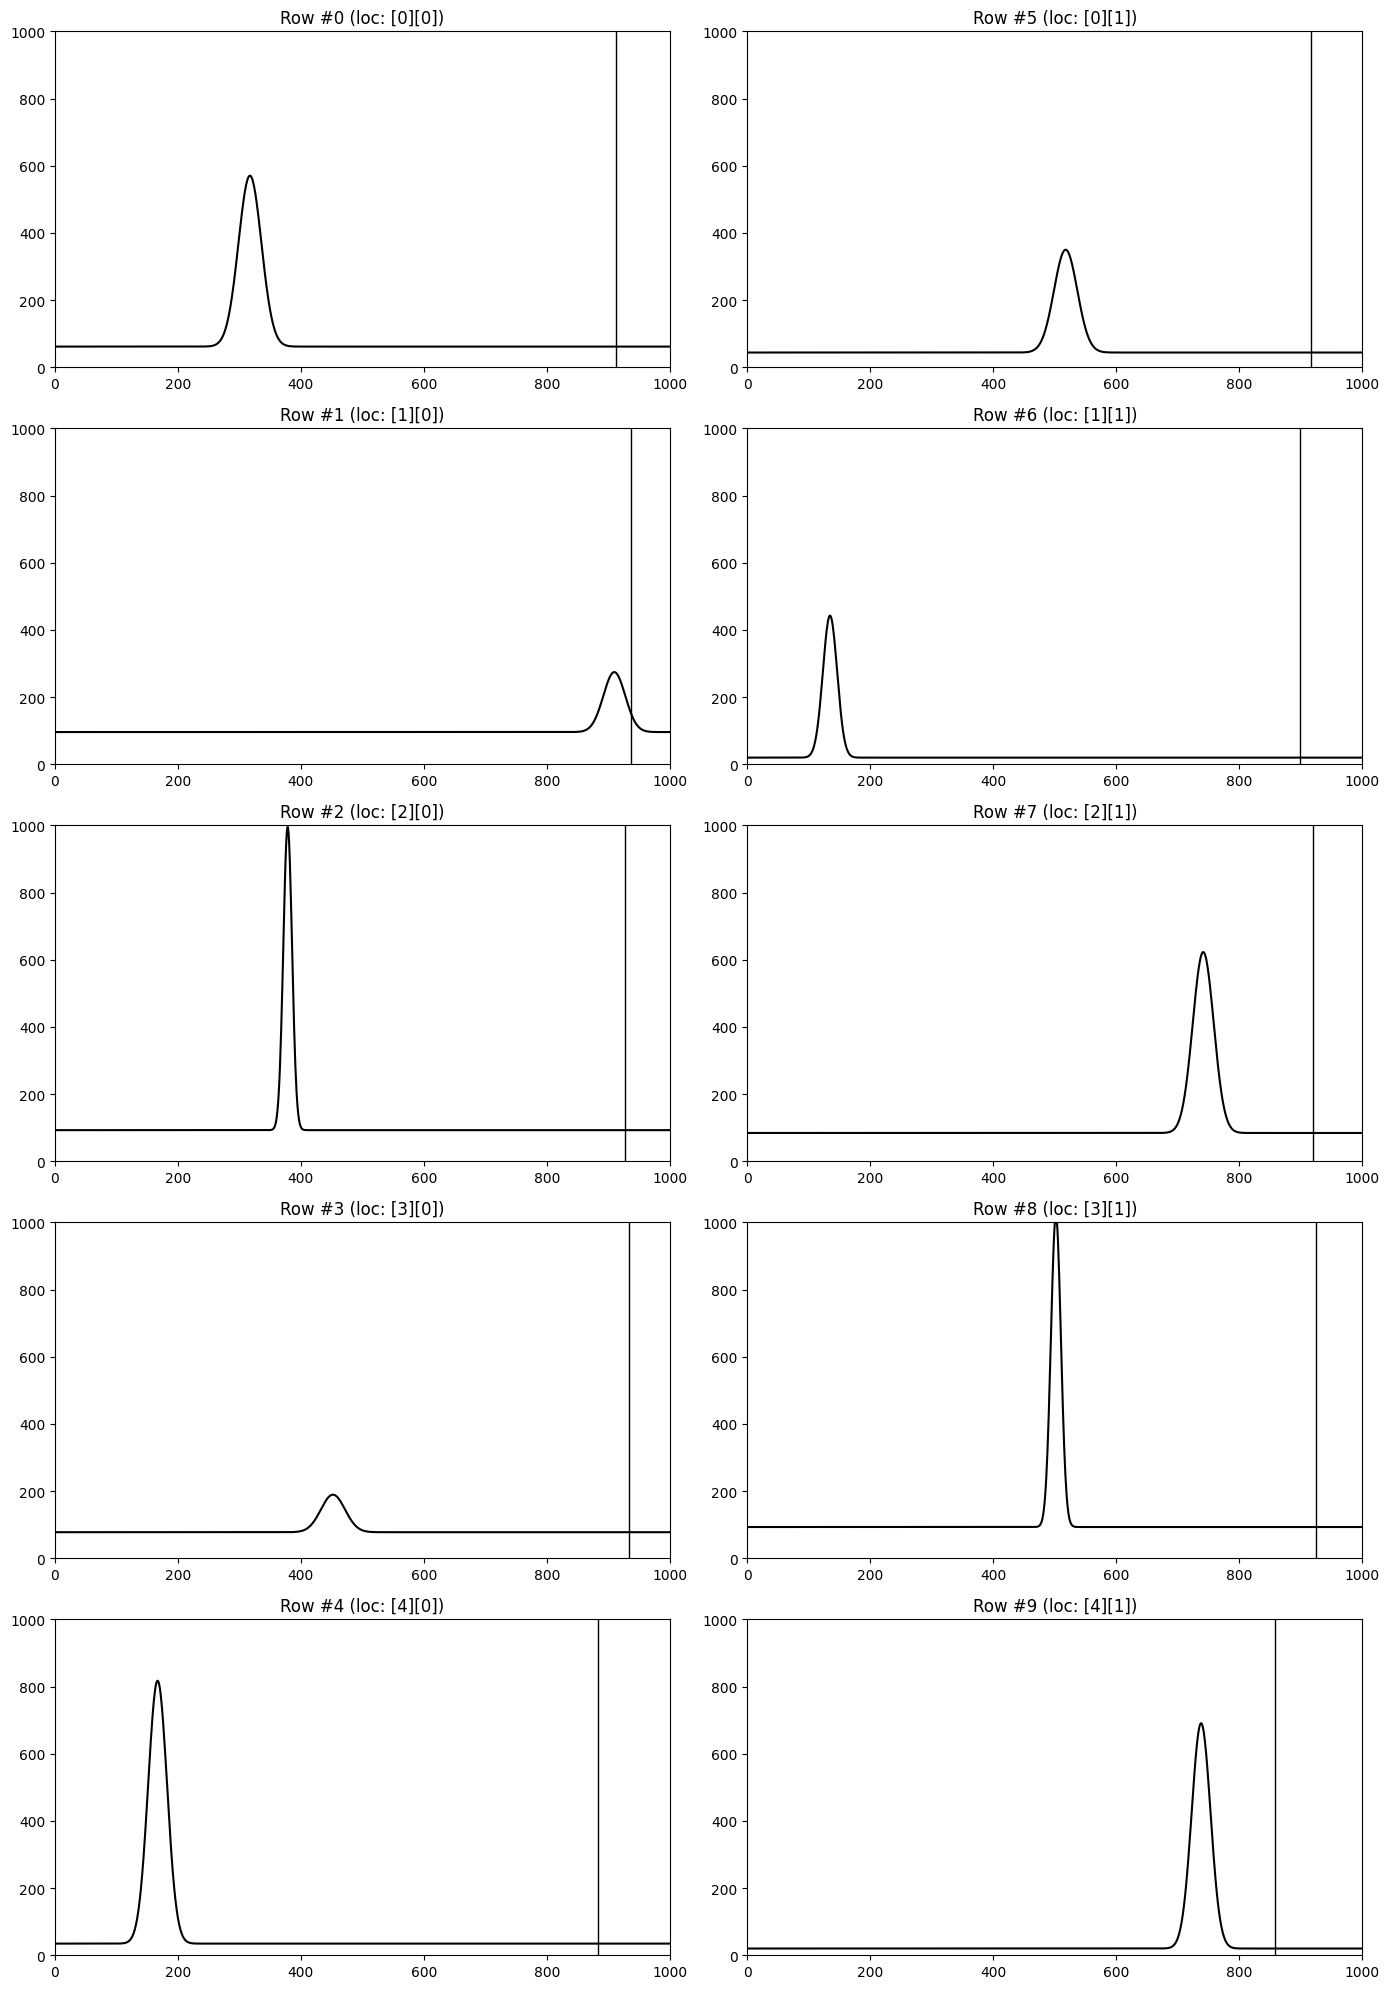

In [68]:
# functions for plotting
df = pd.read_pickle('data/ground-truth.pkl')
def binlvl(idx,len_):
    return int(math.log(len_+1,2) - math.log(math.gcd(idx+1, len_+1),2)) - 1

def plot_eqbins(ebins, ax_, lw = 1, ls='-', cmin = 0, cmax = -1):
    colors = ['r','g','b','k','y','c']
    for idx,e in enumerate(ebins):
        if (cmax!= -1) and ((e < cmin) or (e > cmax)):
            continue
    c = colors[binlvl(idx,len(ebins))]
    ax_.axvline(x = e, color = c, label = 'axvline - full height', linewidth = lw, linestyle=ls)

def plot_gaussian(x, y, edh_bins, ax):
    ax.plot(x, y, 'k-')
    plot_eqbins(edh_bins, ax)

gauss_data_set, edh_bin_set = df.data_pts, df.edh_bds
fig, axes = plt.subplots(5, 2, figsize=(14, 20))
for i in df.index:
    y_set, edh_bins = gauss_data_set[i], edh_bin_set[i]
    ax = axes[i%5][i//5]
    ax.set_xlim(0, len(RES))
    ax.set_ylim(0, len(RES))
    plot_gaussian(np.arange(len(y_set)), y_set, edh_bins, ax)
    ax.title.set_text(f'Row #{i} (loc: [{i%5}][{i//5}])')
fig.tight_layout()
plt.show()

# Data Analysis

New (simpler) plan:
- generate a single ground-truth gaussian with a good spread between bin boundaries and store params
- implement a function that:
    - uses basic regression to generate a gaussian from these params
    - computes new bin boundaries with this gaussian
    - returns the sum squared difference between the original and
      generated boundaries
- use nelder mead minimize to minimize the function
- assume offset and peak width are known constants

## Methodology

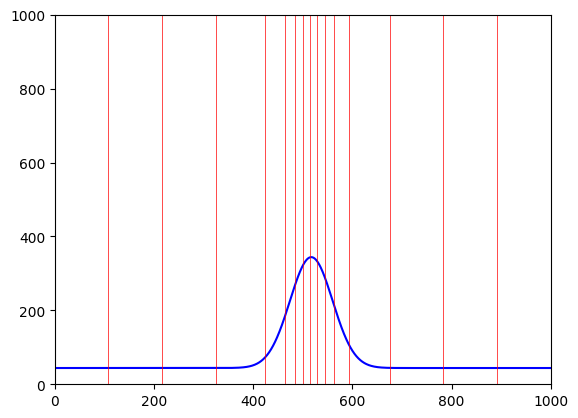

In [52]:
# generate true gaussian
def gen_gauss(x, h, d, w, o):
    return h * np.exp(-(x - d)**2 / (2 * w**2)) + o

# generate edh bin boundaries
def oracle_edh(tr, n_edh):
    bins = tr.shape[-1]
    tr_cs = np.cumsum(tr)
    tr_sum = np.sum(tr)
    edh_bins = np.zeros((n_edh-1))
    for idx in range(edh_bins.shape[-1]):
        edh_bins[idx] = np.argmin(np.abs(tr_cs - tr_sum*(idx+1.0)/n_edh))
    return edh_bins+1

# plot edh bins
def plot_edh_bins(bins, ax):
    for _bin in bins:
        ax.axvline(x=_bin, color='r', linewidth=.5)

h = 300 # peak height
d = 517 # peak offset
w = 43 # peak width
o = 44 # ambient offset

BINS = 16 # number of edh bins
X = np.arange(1000) # length of x axis (laser resolution)

gauss = gen_gauss(X, h, d, w, o)
edh_bins = oracle_edh(gauss, BINS)
                      
fig, ax = plt.subplots()
ax.set_ylim(0, len(X))
ax.set_xlim(0, len(X))
ax.plot(X, gauss, color='b')
plot_edh_bins(edh_bins, ax)
plt.show()

### `curve_fit` from scipy.optimize

- needs predicted values for all parameters in order to function
- also needs bounds in order to fit properly
- can fit a gaussian rather accurately

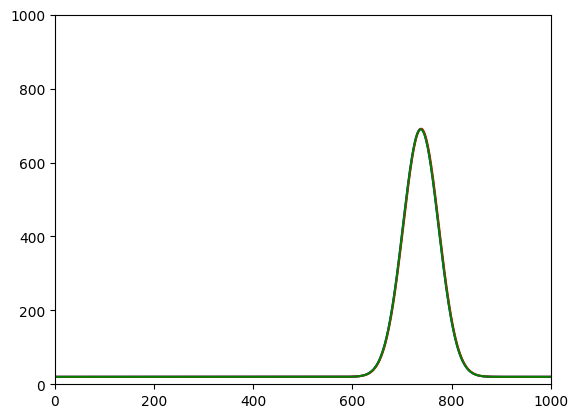

(671.1695302766173, 738.5085131799119, 35.985868263305676, 20.14178613097967)


In [75]:
pred_x, pred_y = convert_ed(edh_bins, edh_bins, len(X), o)
def gauss_wrapper(x, _h, _d):
    return gen_gauss(x, _h, _d, w, o)
p0 = (max(pred_y), len(X)/2)
bounds = (0, len(X))
params, covars = curve_fit(gauss_wrapper, pred_x, pred_y, p0=p0, bounds=bounds)
_h, _d = params
fig, ax = plt.subplots()
ax.set_ylim(0, len(X))
ax.set_xlim(0, len(X))
ax.plot(X, gauss, color='b')
ax.plot(X, gen_gauss(X, _h, _d, w, o), color='r')
h_, d_ = reconstruct_gauss(edh_bins, (w, o), len(X), 'nelder-mead')
ax.plot(X, gen_gauss(X, h_, d_, w, o), color='g')
plt.show()
print(tuple(params)+(w, o))

In [74]:
row = df.loc[9]
h, d, w, o = row.height, row.depth, row.width, row.ambient
gauss = gen_gauss(X, h, d, w, o)
edh_bins = oracle_edh(gauss, BINS)
h, d, w, o

(670.6583046302848, 737.684602969965, 35.985868263305676, 20.14178613097967)

## Implementation

In [45]:
# Implementation Function
def reconstruct_gauss(bds, knowns, res, model):
    # get already known peak width and dc offset
    wid, off = knowns

    # use least squares to fit a predicted curve to the bins
    pred_x_, pred_y_ = convert_ed(bds, bds, res, off) # TODO: need to adjust this function so it's only reliant on bins
    # define wrapper function for curve fit
    def wrapper(_range, _height, _depth):
        return gen_gauss(_range, _height, _depth, wid, off)
    p0 = (max(pred_y_), res/2)
    bounds = (0, res)
    unknowns, covars = curve_fit(wrapper, pred_x_, pred_y_, p0=p0, bounds=bounds)

    # using the params from the fitted curve, minimize predicted curve until it's edh is equal to the known edh
    pred_params = minimize(cost_func, unknowns, args=(knowns, bds), method=model)

    # return predicted height and depth
    return pred_params.x

def cost_func(unknowns, knowns, target):
    _h, _d = unknowns
    w, o = knowns
    pred = oracle_edh(gen_gauss(RES, _h, _d, w, o), 16)
    return np.sum((pred-target)**2)

def pe(expected, predicted):
    return abs((predicted-expected) / expected)

def mse(expected, predicted):
    return np.sum((expected-predicted)**2) / predicted.size

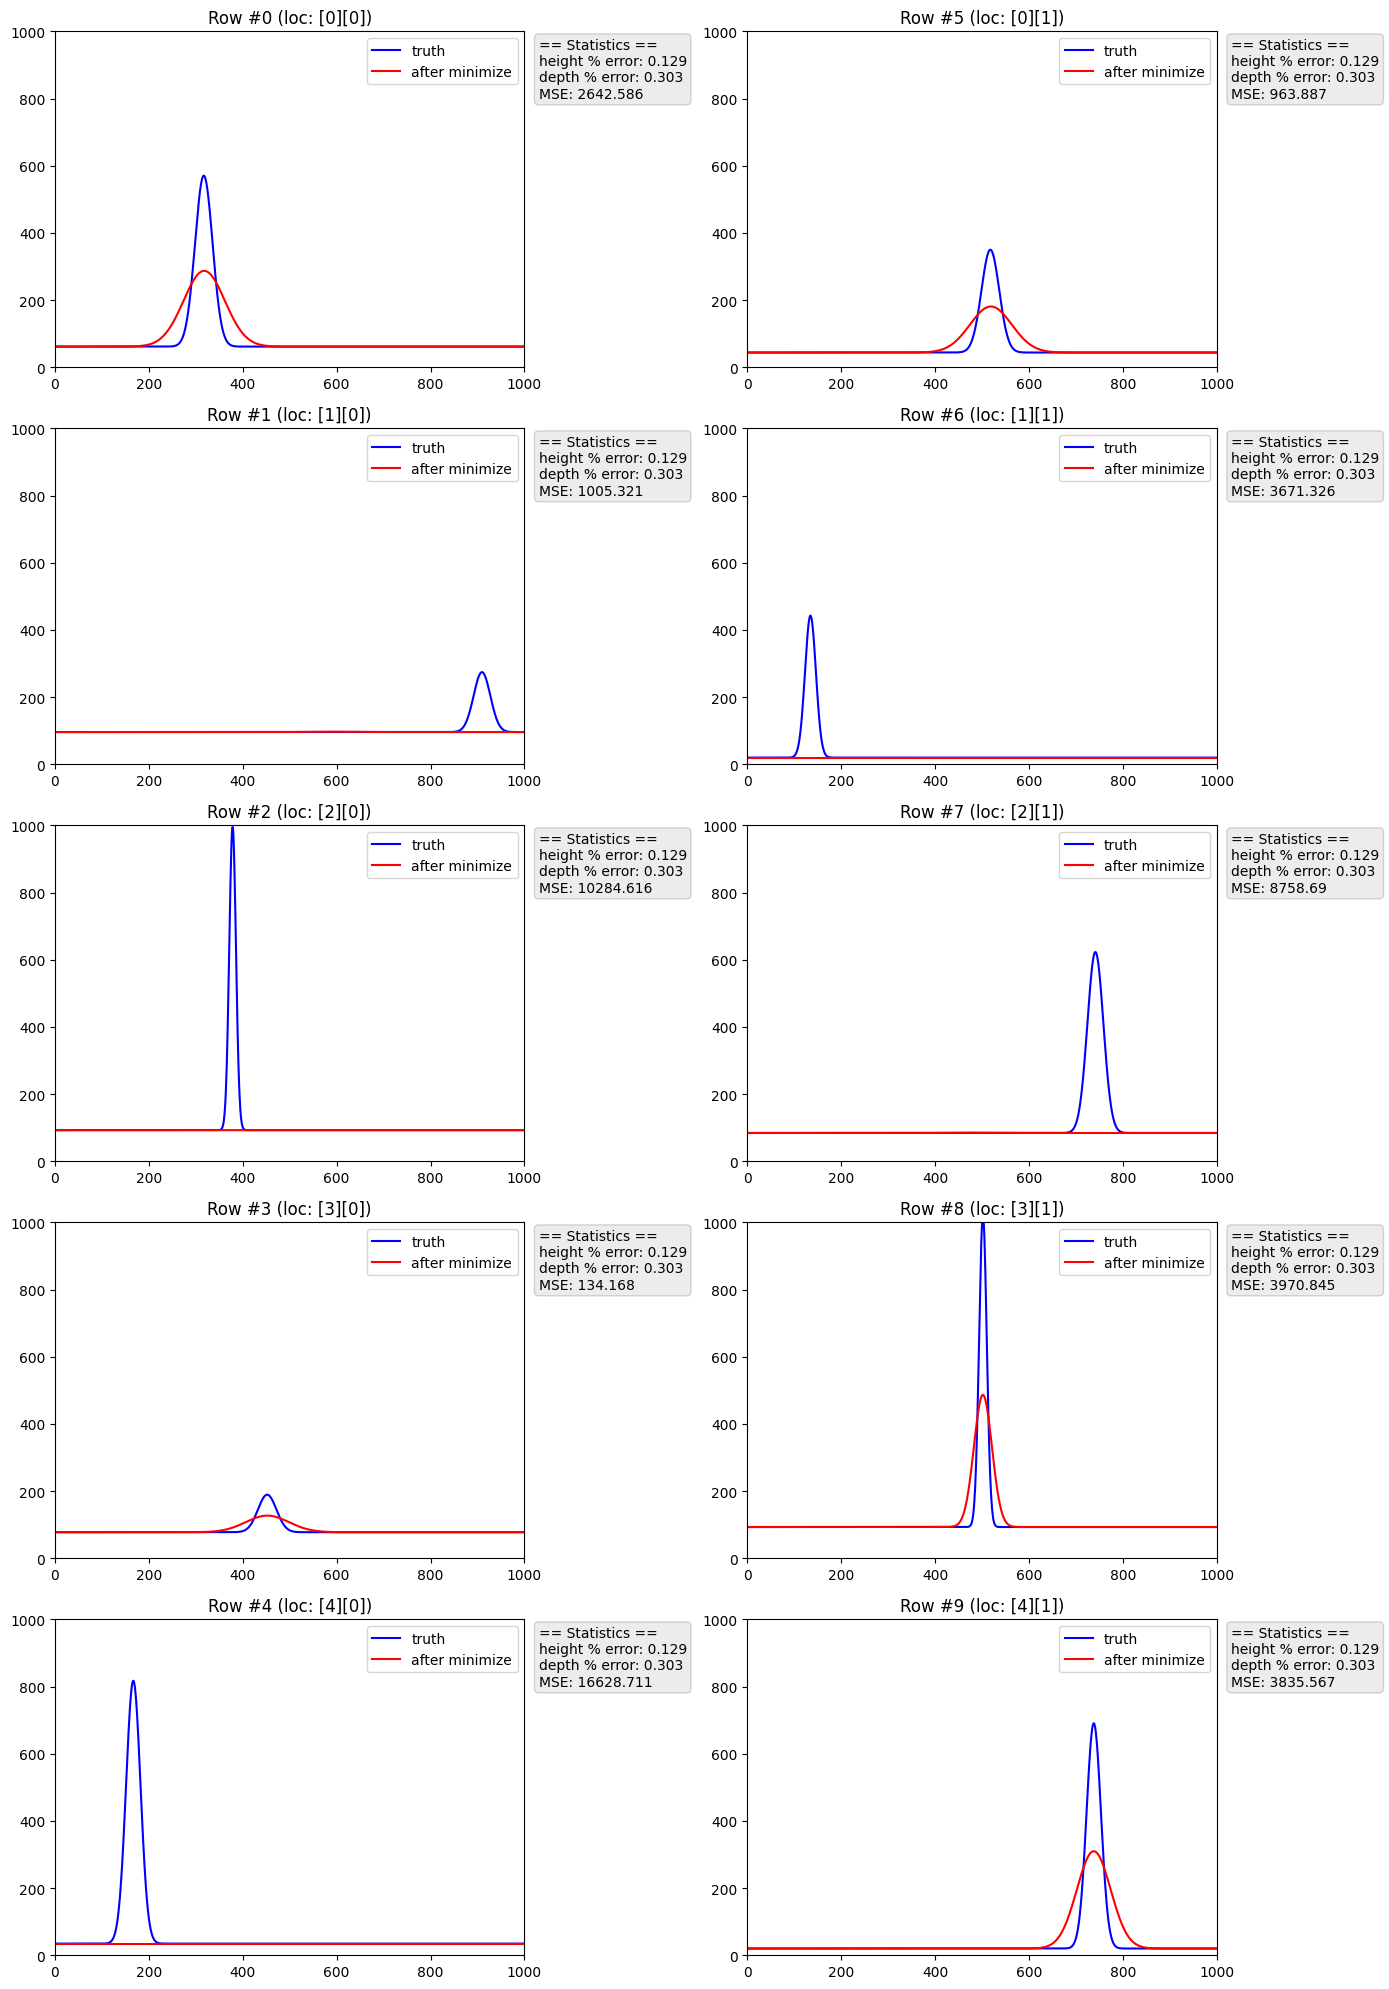

In [60]:
# Constraints
MODEL = 'nelder-mead'
RES = np.arange(1000) # TODO: store this in the dataframe itself

BBOX_PROPS = {'boxstyle': 'round', 'facecolor': 'gray', 'alpha': 0.15}

# Test
fig, axes = plt.subplots(5, 2, figsize=(14, 20))
df = pd.read_pickle('data/ground-truth.pkl')
for i in df.index:
    row = df.loc[i]
    height, depth, width, offset = row.height, row.depth, row.width, row.ambient
    pred_params = reconstruct_gauss(row.edh_bds, (width, offset), len(RES), MODEL)
    height_, depth_ = pred_params
    pred_y = gen_gauss(RES, height_, depth_, width, offset)
    
    ax = axes[i%5][i//5]
    ax.set_xlim(0, len(RES))
    ax.set_ylim(0, len(RES))
    ax.plot(RES, row.data_pts, color='b', label='truth')
    
    # _x, _y = convert_ed(row.edh_bds, row.edh_bds, RES, row.ambient)
    # _h, _d, _w, _o = curve_fit(gen_gauss, _x, _y, p0=(max(_y), len(RES)/2, row.width, row.ambient), bounds=(0, len(res)))[0]
    # ax.plot(RES, gen_gauss(RES, _h, _d, _w, _o), color='m', label='after curve_fit')
    
    ax.plot(RES, pred_y, color='r', label='after minimize')

    description = '== Statistics ==\n'
    description += f'height % error: {round(pe(h, h_), 3)}\n'
    description += f'depth % error: {round(pe(d, d_), 3)}\n'
    description += f'MSE: {round(mse(row.data_pts, pred_y), 3)}'
    ax.text(1.03, 0.98, description, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=BBOX_PROPS)
    ax.title.set_text(f'Row #{i} (loc: [{i%5}][{i//5}])')
    ax.legend()
fig.tight_layout()